## Feature Analysis

To analyze what are the most important indicators whether a team will win or lose, we will now build a simple binary predictor model and study which are the variables which help predict wins and losses more.

Since we are only trying to analyze the features, we will use the same game variables for our x values, since the aim is not build predictions.

To analyze the importance of the features, we will use the following models:

* Logistics Regression
* Random Forest Classifier
* Gradient Boost Classifier
* XGBoost Classifier

In [1]:
import pandas as pd
import numpy as np
import copy

from pathlib import Path

from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import joblib

import seaborn as sns

from modules.model import Model, ML_Model

import plotly.express as px

from IPython.display import Image
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.simplefilter('ignore')

In [2]:
team_data = pd.read_csv(f'./data/team_data.csv')

For this model, this will be the following features we will include:

* fg3a
* fg2a
* fta
* fg3_pct
* fg2_pct
* ft_pct
* ast_ratio
* team_tov_pct
* team_orb_pct
* team_efg_pct

Our target variable will be the Win variable

In [3]:
x_vars = ['fg3a', 'fg2a', 'fta', 'fg3_pct', 'fg2_pct', 'ft_pct', 'ast_ratio', 'team_tov_pct', 'team_orb_pct', 'team_efg_pct']
y_var = ['win']

In [4]:
model_data = team_data.copy(deep=True)
model_data.columns = [x.lower().strip() for x in model_data.columns]
model_data = model_data[x_vars + y_var]
model_data.head()

,fg3a,fg2a,fta,fg3_pct,fg2_pct,ft_pct,ast_ratio,team_tov_pct,team_orb_pct,team_efg_pct,win
0,33,52,21,0.393939,0.461538,0.714286,15.595758,12.9,20.9,0.512,0
1,31,50,24,0.354839,0.620000,0.708333,18.524236,13.3,25.6,0.586,1
2,45,57,20,0.422222,0.421053,0.850000,18.773467,14.6,28.1,0.515,0
3,40,63,38,0.350000,0.444444,0.842105,14.490927,11.8,30.2,0.476,1
4,43,65,28,0.302326,0.507692,0.785714,14.713408,9.8,24.0,0.486,1


### Min Max Scale data

In [5]:
# min max scale variables
min_max_scaler = MinMaxScaler(feature_range=(0,1))

# scale on the whole dataframe, win variable already binary
scaled_data = min_max_scaler.fit_transform(model_data)

# model data scaled
model_data_scaled = pd.DataFrame(scaled_data, columns=model_data.columns)
model_data_scaled.head()

,fg3a,fg2a,fta,fg3_pct,fg2_pct,ft_pct,ast_ratio,team_tov_pct,team_orb_pct,team_efg_pct,win
0,0.433962,0.367647,0.369565,0.525665,0.413484,0.587302,0.413687,0.444030,0.427403,0.427126,0.0
1,0.396226,0.338235,0.434783,0.460829,0.691432,0.578704,0.547219,0.458955,0.523517,0.576923,1.0
2,0.660377,0.441176,0.347826,0.572562,0.342470,0.783333,0.558583,0.507463,0.574642,0.433198,0.0
3,0.566038,0.529412,0.739130,0.452806,0.383500,0.771930,0.363310,0.402985,0.617587,0.354251,1.0
4,0.622642,0.558824,0.521739,0.373754,0.494440,0.690476,0.373455,0.328358,0.490798,0.374494,1.0


### Heatmap for feature correlation

In [6]:
import plotly.graph_objects as go

def heatmap(vars_heat: list):
    fig = go.Figure(data=go.Heatmap(
                    z=model_data[vars_heat].corr(),
                    x=model_data[vars_heat].columns,
                    y=model_data[vars_heat].columns,
                    hoverongaps=False))
    fig.show()

heatmap(x_vars)

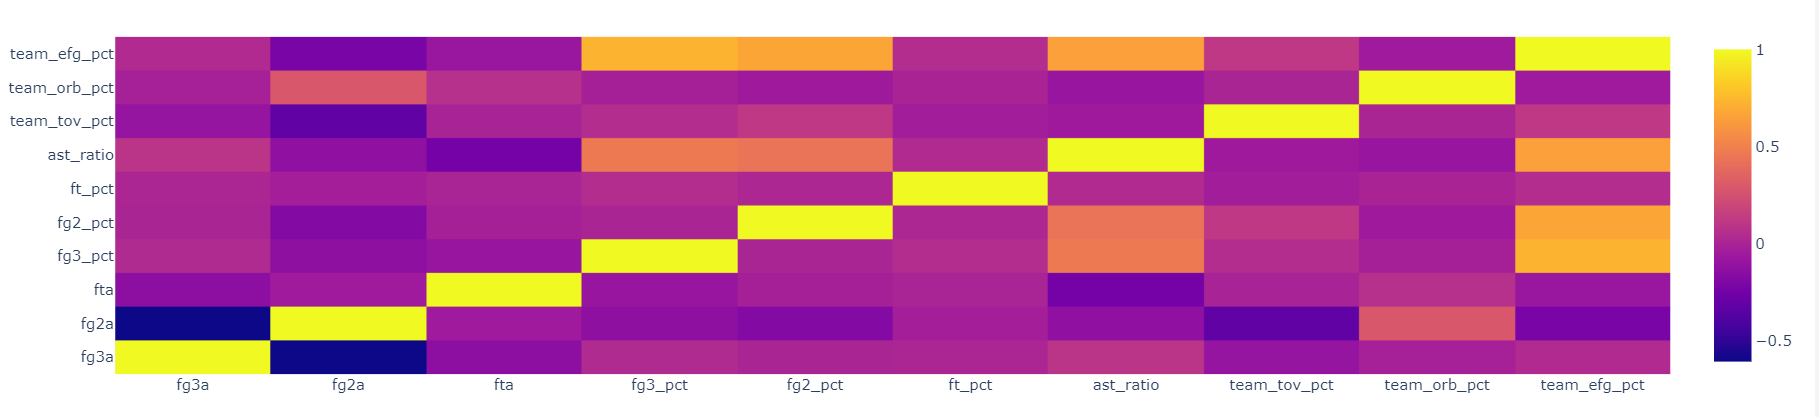

In [7]:
Image('./images/heatmap_all_vars.png')

So from the heatmap above, we see that there are a couple of high correlations we need to take into account:

* Team efg_pct is highly correlated with ast_ratio, fg2_pct and fg3_pct
* Assist ratio is highly correlated with fg3_pct and fg2_pct
* Fg3a is negatively correlated with fg2a

Between the rest of the variables there doesnt seem to be any other worrisome correlations, but we will need to define a list of base variables which have very low correlations, which can serve as the baseline for the tuning process in the classifiers

In [8]:
base_x = ['fg3a', 'fta', 'ft_pct', 'team_tov_pct', 'team_orb_pct']
heatmap(base_x)

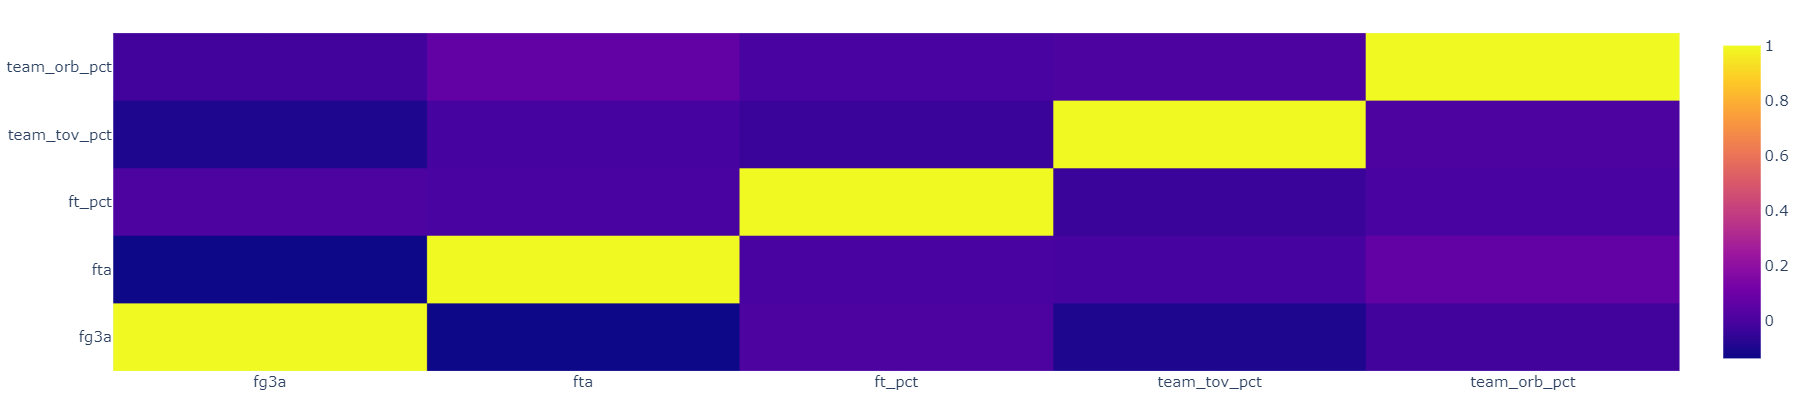

In [9]:
Image('./images/heatmap_0.png')

It seems like the 5 variables above are the ones that are not correlated, as we see in the heatmap above. Therefore, as a baseline, we can use 4-5 as the parameter for max-features.

In [10]:
x_1 = base_x + ['team_efg_pct']
x_2 = base_x + ['ast_ratio']
x_3 = base_x + ['fg3_pct', 'fg2_pct']

heatmap(x_1)
heatmap(x_2)
heatmap(x_3)

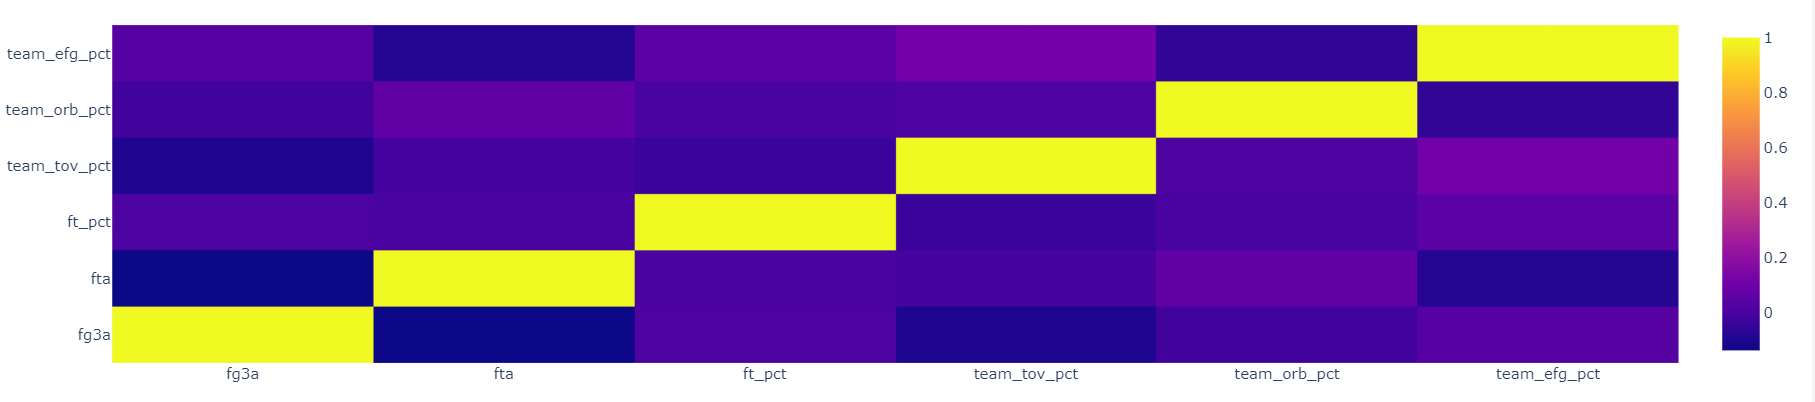

In [11]:
Image('./images/heatmap_1.png')

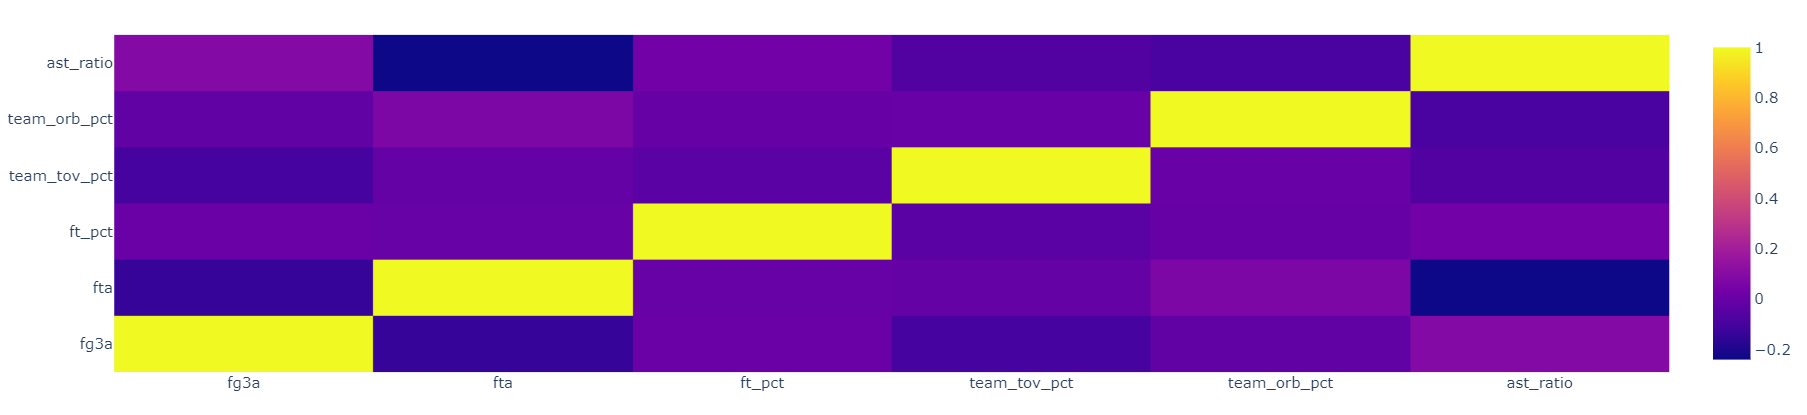

In [12]:
Image('./images/heatmap_2.png')

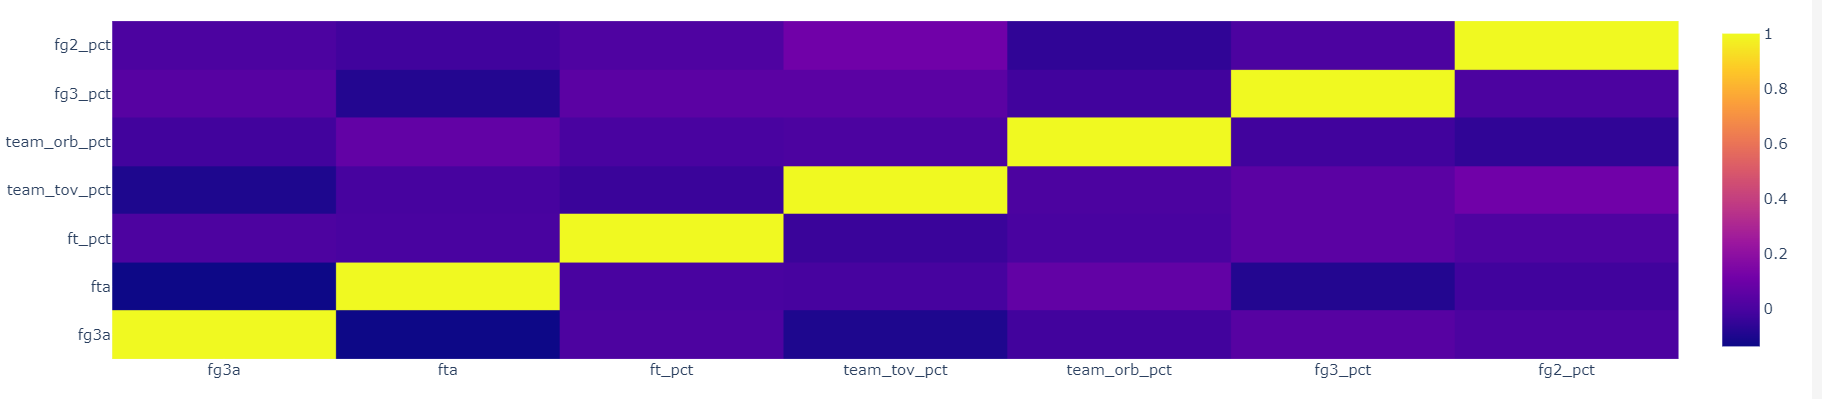

In [13]:
Image('./images/heatmap_3.png')

In the 3 heatmaps above, we see very low correlations between the set of features, therefore we can advance and train different models based on these features, and assess the impact of fg3a on winning

In [14]:
feature_sequences = [base_x, x_1, x_2, x_3]

### Variance Selection

Since the variables all have different ranges to them, we will min max scale all variables above

In [15]:
# define vars for train test split

TEST_SIZE = 0.2
SEED = 4

In [16]:
X, y = model_data_scaled[x_vars].values, model_data_scaled[y_var].values

### Feature Analysis with tree based models

In [17]:
# define models and the parameter grid for which to search
rf = {"name": "rf", "classifier": RandomForestClassifier(), 'searcher':GridSearchCV\
    , "param_grid": {"max_depth":[4,5,6,7,8], "n_estimators":[150,200,250,300,400]}, \
        'max_features': [4,5,6,7]}

gb = {"name": "gb", "classifier": GradientBoostingClassifier(), 'searcher':RandomizedSearchCV\
    , "param_distributions": {"max_depth":[4,5,6,7,8], "n_estimators":[150,200,250,300,400], \
        "learning_rate": [0.1, 0.05, 0.01, 0.001], 'max_features': [4,5,6,7], \
            'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]}}

xgb = {"name": "xgb", "classifier": XGBClassifier(verbosity = 0), 'searcher':RandomizedSearchCV\
    , "param_distributions": {"max_depth":[4,5,6,7,8], "n_estimators":[150,200,250,300], \
        "eta": [0.1, 0.05, 0.01, 0.001], 'max_features': [4,5,6,7], \
            'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]}}

algorithms_params = [xgb, gb, rf]

In [18]:
# define cross validation searchers
gridsearch, randomsearch = GridSearchCV, RandomizedSearchCV

In [19]:
def run_model_commands(model, searcher: object, searcher_params: dict, \
    metrics: list=["accuracy"], test_size: float=0.2):
    
    """
    function to run the commands of a model object
    """
    model.get_best_params(searcher=searcher, searcher_params=searcher_params, \
        metrics=metrics)
    model.set_params(params_to_set=model.best_params)
    model.train_test_split(test_size=test_size)
    model.train_model()
    model.test_model()

In [20]:
estimators = {}

y = model_data_scaled[y_var].values

# run through the different algorithms chosen
for algorithm in algorithms_params:

    # enumrate to keep a constant copy
    for keys, values in enumerate(feature_sequences):

        X = model_data_scaled[values].values

        # create a deep copy of the object
        algorithm_copy = copy.deepcopy(algorithm)

        # create the object for the model
        model = ML_Model(X=X, y=y, base_model=algorithm_copy["classifier"], \
            seed=SEED)

        # define searcher and searcher params
        searcher=algorithm_copy['searcher']
        params={'estimator': model.base_model, 'scoring':'accuracy', 'n_jobs':-1}

        # add the param distribution based on the searcher
        if searcher==GridSearchCV:
            params['param_grid'] = algorithm_copy['param_grid']
        else:
            params['param_distributions'] = algorithm_copy['param_distributions']
            params['n_iter'] = 15

        name = algorithm_copy['name']

        # run the commands from the class necessary to create the model
        print(f"running commands {name}_{keys} & {'accuracy'}...")
        print(f'var_list: {values}')
        run_model_commands(model=model, searcher=searcher, searcher_params=params, \
            metrics=['accuracy'])

        print("storing model ...")

        # storing the file
        file_object = Path(f"models/{name}_model{keys}.pkl").open("wb")
        joblib.dump(model.base_model, file_object)

        # create feature importances
        model.feature_importances(x_vars=values, name=name, instance=f"{name}_{keys}")
        # saving it in the dictionary
        estimators[f"{algorithm_copy['name']}_accuracy_{keys}"] = model

running commands xgb_0 & accuracy...
var_list: ['fg3a', 'fta', 'ft_pct', 'team_tov_pct', 'team_orb_pct']
searching for best parameters
Best score: 0.5869703158369574
Model train score: 0.6784786641929499
Model test score: 0.5816023738872403
storing model ...
running commands xgb_1 & accuracy...
var_list: ['fg3a', 'fta', 'ft_pct', 'team_tov_pct', 'team_orb_pct', 'team_efg_pct']
searching for best parameters
Best score: 0.732557955130148
Model train score: 0.7860853432282003
Model test score: 0.7314540059347181
storing model ...
running commands xgb_2 & accuracy...
var_list: ['fg3a', 'fta', 'ft_pct', 'team_tov_pct', 'team_orb_pct', 'ast_ratio']
searching for best parameters
Best score: 0.6678561359487443
Model train score: 0.7120593692022263
Model test score: 0.6624629080118695
storing model ...
running commands xgb_3 & accuracy...
var_list: ['fg3a', 'fta', 'ft_pct', 'team_tov_pct', 'team_orb_pct', 'fg3_pct', 'fg2_pct']
searching for best parameters
Best score: 0.7327094067396407
Model t

In [44]:
# accuracy list
accuracies=[]

# get accuracies chart
for key, values in estimators.items():
    accuracies.append([key, estimators[key].test_score])

# create dataframe
accuracies_df = pd.DataFrame(data=accuracies, columns=['model', 'test_accuracy'])

In [47]:
@dataclass
class BoxChart():


    estimators: dict


    def consolidate_dfs(self):
        """
        Parameters:
            estimators (dict): A dictionary containing the estimators to be consolidated.

        Returns:
            pd.DataFrame: A pandas DataFrame object containing the consolidated dataframes from the estimators.
        """
        
        return pd.concat([estimators[key].importances_df for (key, v) in self.estimators.items()])


    def feature_importance_chart(self, multiplier:int=1):
        """
        Parameters:
        estimators (dict): A dictionary containing the estimators to be visualized.

        Returns:
        None: The boxplot is displayed in a new window.
        """

        df = self.consolidate_dfs()
        self.fig=px.box(data_frame=df, x='feature', y='score', color='model')
        self.button_layout(buttons = ['xgb', 'gb', 'rf'], multiplier=multiplier)
        self.fig.show()

    
    def feature_importance_chart_bar(self, multiplier:int=4):
        """
        Parameters:
        estimators (dict): A dictionary containing the estimators to be visualized.

        Returns:
        None: The boxplot is displayed in a new window.
        """

        df = self.consolidate_dfs()
        self.fig=px.bar(data_frame=df, x='feature', y='score', color='model_instance', barmode='group')
        self.button_layout(buttons = ['xgb', 'gb', 'rf'], multiplier=multiplier)
        self.fig.show()


    def button_layout(self, buttons:list, multiplier:int):

        def button_organizer(buttons:list=buttons):
            
            buttons_output=[]
            buttons_length=len(buttons)

            none_button=dict(label="None", method="update", args=[{"visible":[True]}, {"title":"ALL"}])
            buttons_output.append(none_button)

            base_array=[False]*buttons_length*multiplier

            for key, button in enumerate(buttons):

                button_array = copy.deepcopy(base_array)
                button_array[key*multiplier:(key*multiplier)+multiplier] = [True]*multiplier
                button_model=dict(label=f"{button}", method="update", args=[{"visible":button_array}, {"title":f"{button}"}])
                buttons_output.append(button_model)

            return buttons_output

        self.fig.update_layout(updatemenus=[dict(active=0,buttons=list(button_organizer(buttons)))])

In [48]:
box = BoxChart(estimators=estimators)
box.feature_importance_chart()

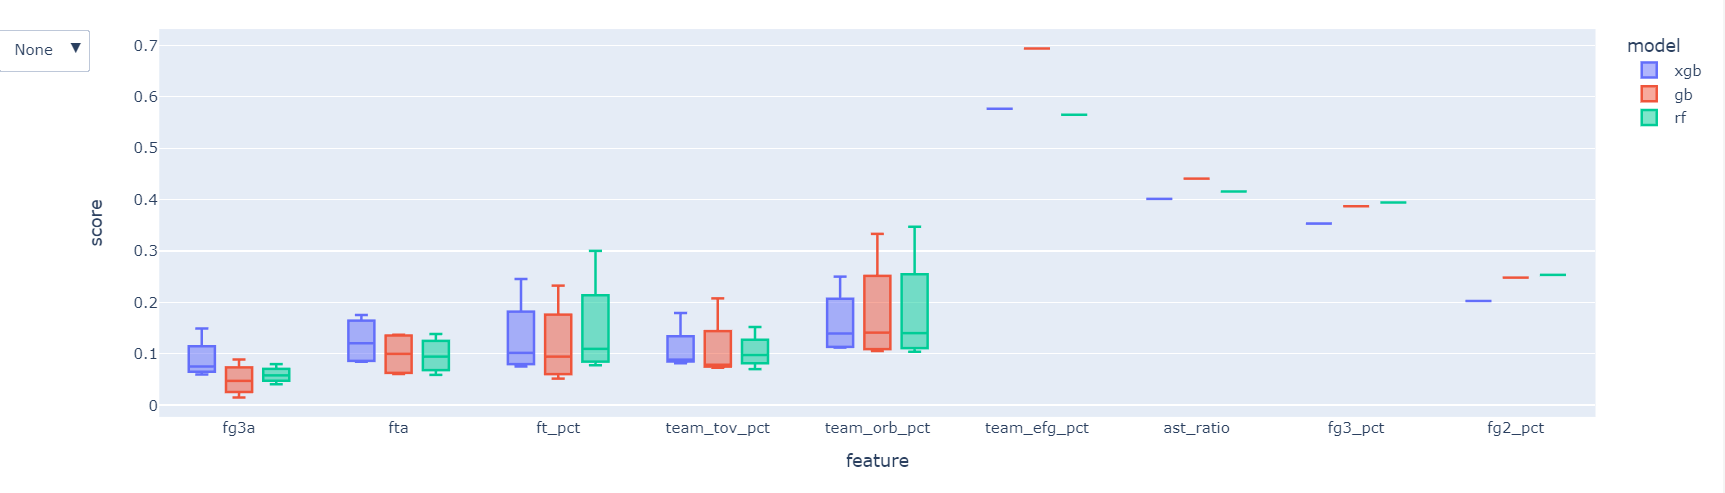

In [49]:
Image('./images/feat_importance_agg_model.png')

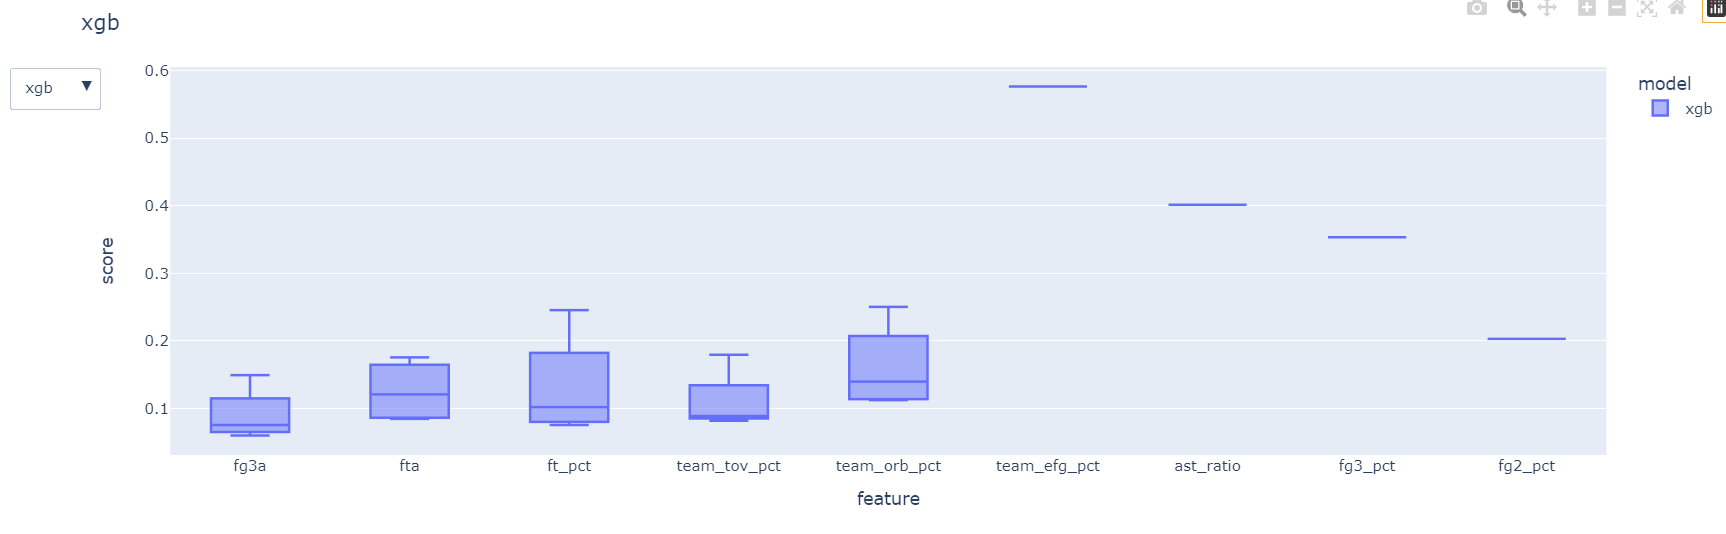

In [53]:
Image('./images/xgb_feature_importances_bx.png')

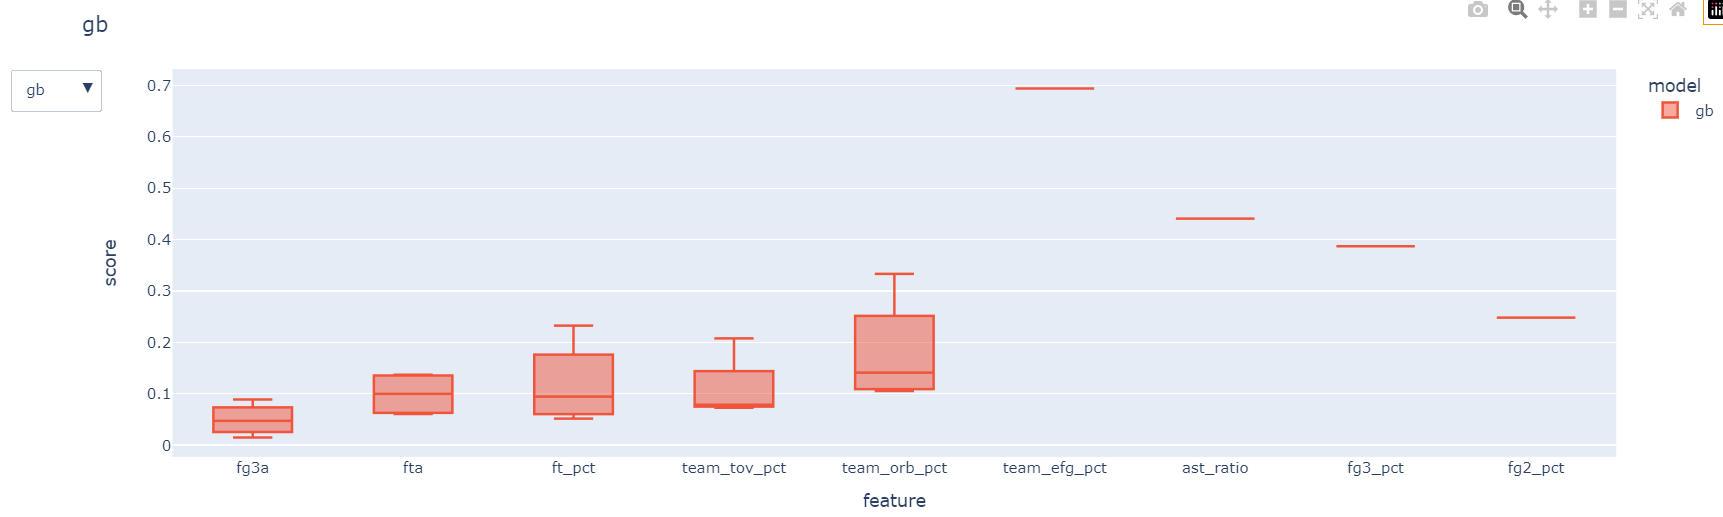

In [54]:
Image('./images/gb_feature_importances_bx.png')

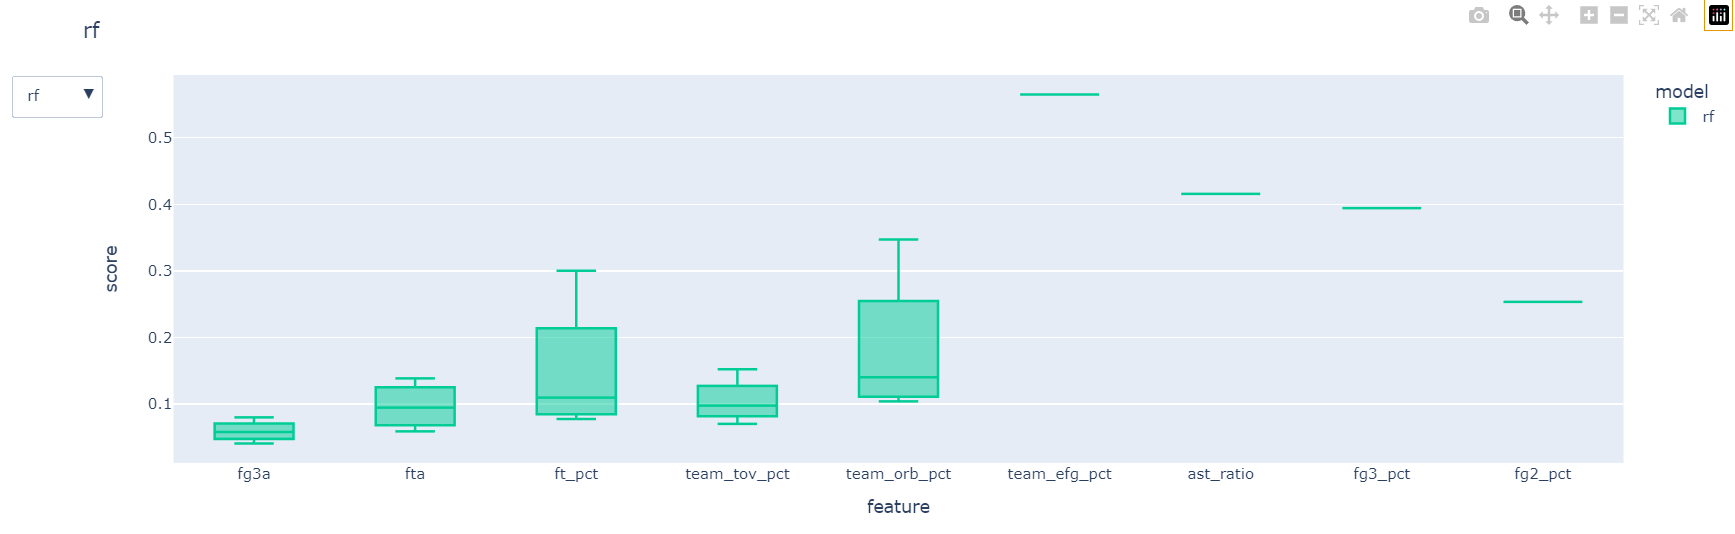

In [55]:
Image('./images/rf_feature_importances_bx.png')

As we can see from the graph above, fg3a have a relatively low importance in the models. From the variables above, fg3a had the lowest median scores across models. To have more detail, we can also see by model instance how fg3a scored in each model.

In [56]:
box.feature_importance_chart_bar()

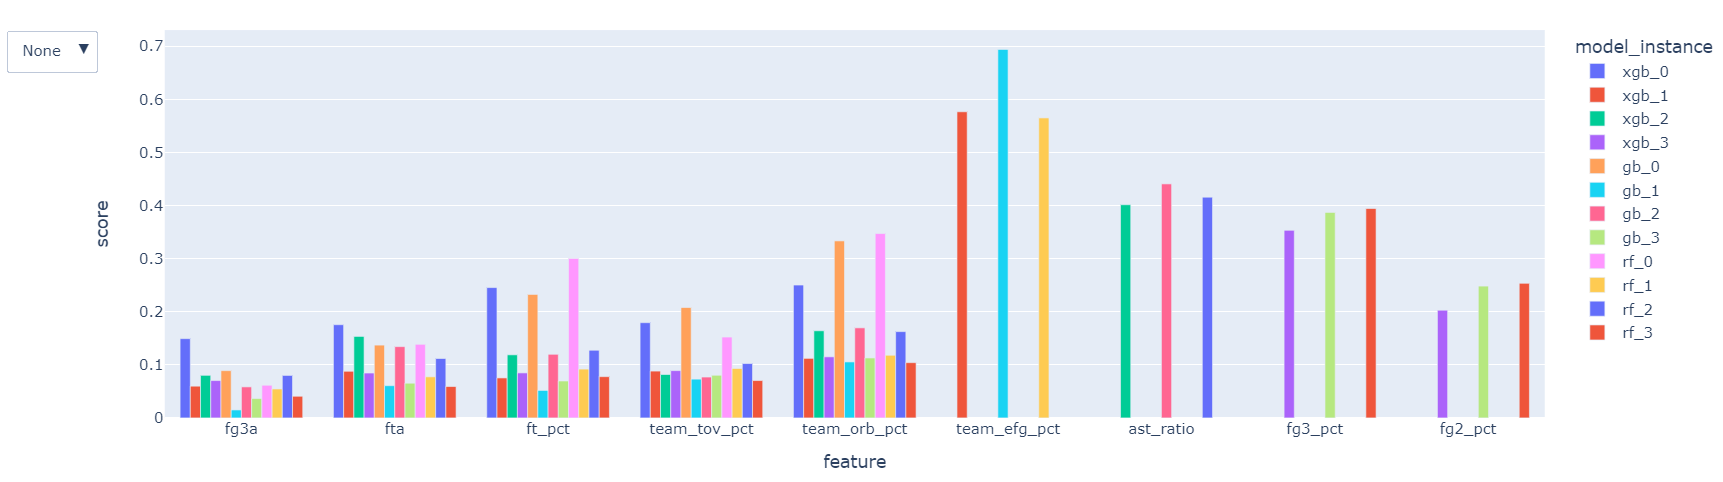

In [57]:
Image('./images/feat_importance_model.png')

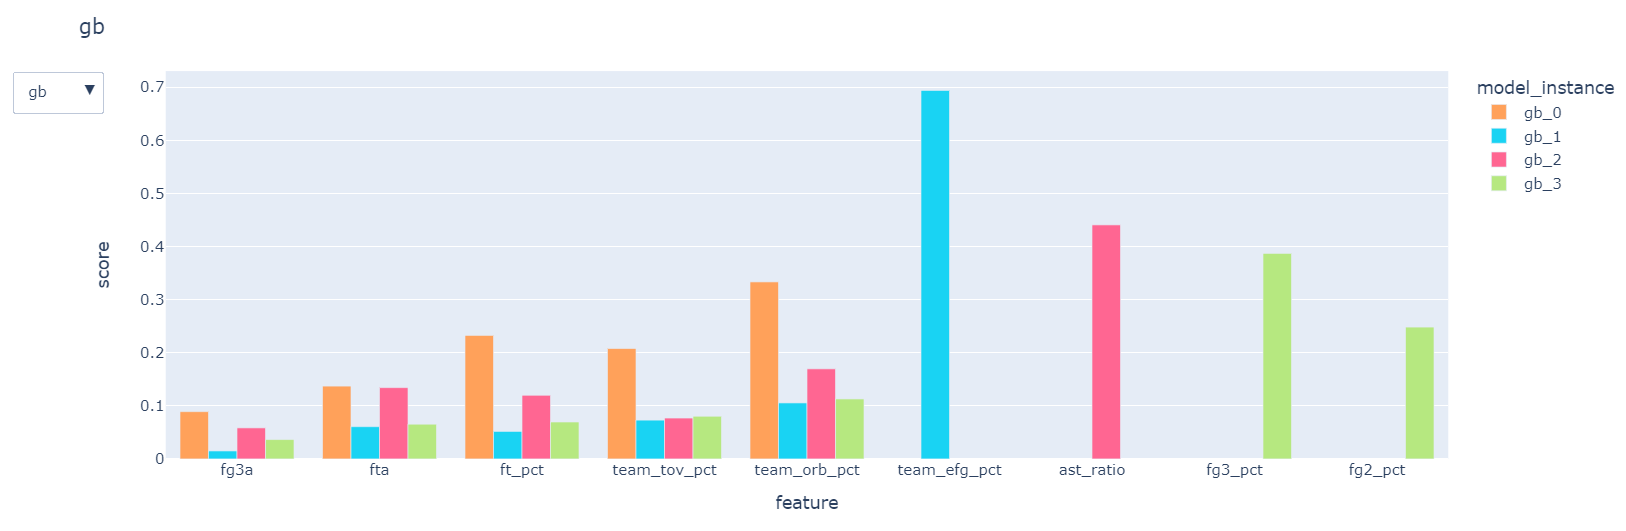

In [58]:
Image('./images/gb_feature_importances_bar.png')

In [59]:
# print test scores
print(accuracies_df)

             model  test_accuracy
0   xgb_accuracy_0       0.581602
1   xgb_accuracy_1       0.731454
2   xgb_accuracy_2       0.662463
3   xgb_accuracy_3       0.729228
4    gb_accuracy_0       0.580861
5    gb_accuracy_1       0.741098
6    gb_accuracy_2       0.660979
7    gb_accuracy_3       0.726261
8    rf_accuracy_0       0.577151
9    rf_accuracy_1       0.740356
10   rf_accuracy_2       0.664688
11   rf_accuracy_3       0.724036


As we can see from the chart above, fg3a scored high only in xgb models, where overfitting is more prone, while in instances of gradient boosting and random forest models, 3 point field goal attempts decreased. Especially for models with high test accuracies, above 0.70, the feature importance score is around or below 0.05.

